# 1.9h: Full Neighborhood Adjacency Graph (Unique Vectors)

From 1.9g we found 39 singleton tokens in the exponent-matched neighborhood (plus 2,100 BH tokens).

**Question:** How do these singletons connect to the 13 black holes and to each other?

**Method:**
1. Load the full exponent-matched neighborhood (2,139 tokens)
2. **Extract unique vectors** (13 BH centroids + ~39 singleton vectors = ~52 nodes)
3. Build adjacency graph over unique vectors: edges where vectors differ by 1 uint16 step in ≥1 dimension
4. Compute graph properties:
   - Connected components
   - Degree distribution (BHs vs singletons)
   - Betweenness centrality
   - Edge types (BH-BH, BH-singleton, singleton-singleton)
5. Visualize the structure

**Expected result:** Core-periphery topology — dense BH core with sparse singleton halo.

**Performance:** ~52² × 2,560 = ~7M comparisons instead of ~11.7B (1,600x speedup)

## Parameters

In [16]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c (for reference)
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

## Imports

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict, Counter
from tqdm import tqdm

## Load Data

In [18]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [19]:
# Load black hole data from 1.9b
bh_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
bh_data = load_file(bh_path)

core_token_ids = bh_data["core_token_ids"].to(torch.int64)
bh_labels = bh_data["bh_labels"].to(torch.int64)
n_black_holes = bh_data["n_black_holes"].item()

print(f"\nLoaded black hole data: {n_black_holes} black holes")


Loaded black hole data: 13 black holes


In [20]:
# Load neighborhood data from 1.9g
nbhd_path = Path(f"../tensors/{MODEL_NAME}/1.9g_local_neighborhood.safetensors")
nbhd_data = load_file(nbhd_path)

# Full neighborhood (BHs + singletons)
full_neighborhood_token_ids = nbhd_data["full_neighborhood_token_ids"].to(torch.int64)
n_full_neighborhood = nbhd_data["n_full_neighborhood"].item()

# Local neighborhood (singletons only)
local_neighborhood_token_ids = nbhd_data["local_neighborhood_token_ids"].to(torch.int64)
n_local_neighborhood = nbhd_data["n_local_neighborhood"].item()

print(f"\nLoaded neighborhood data:")
print(f"  Full neighborhood: {n_full_neighborhood:,} tokens")
print(f"  Local neighborhood (singletons): {n_local_neighborhood:,} tokens")


Loaded neighborhood data:
  Full neighborhood: 2,139 tokens
  Local neighborhood (singletons): 39 tokens


## Extract Unique Vectors

In [21]:
print("\nExtracting unique vectors from neighborhood...\n")

# Get all vectors in the neighborhood
neighborhood_vectors_bf16 = W_bf16[full_neighborhood_token_ids]

# Convert to uint16 for exact comparison
neighborhood_vectors_uint16 = neighborhood_vectors_bf16.cpu().view(torch.uint16).numpy()

# Find unique vectors using numpy
# Returns: unique vectors, indices of first occurrence, inverse mapping
unique_vectors, first_occurrence_idx, inverse_mapping = np.unique(
    neighborhood_vectors_uint16, 
    axis=0, 
    return_index=True, 
    return_inverse=True
)

n_unique = len(unique_vectors)

print(f"✓ Found {n_unique} unique vectors")
print(f"  From {len(full_neighborhood_token_ids):,} total tokens")
print(f"  Compression ratio: {len(full_neighborhood_token_ids) / n_unique:.1f}x")
print()

# Build mapping: unique_idx -> list of token IDs with that vector
unique_to_tokens = defaultdict(list)
for token_idx, unique_idx in enumerate(inverse_mapping):
    token_id = full_neighborhood_token_ids[token_idx].item()
    unique_to_tokens[unique_idx].append(token_id)

# Get representative token ID for each unique vector (first occurrence)
unique_token_ids = [full_neighborhood_token_ids[idx].item() for idx in first_occurrence_idx]

# Categorize each unique vector as BH or singleton
bh_token_ids_set = set(core_token_ids[bh_labels >= 0].tolist())
singleton_token_ids_set = set(local_neighborhood_token_ids.tolist())

unique_labels = []  # 'BH' or 'singleton'
unique_populations = []  # How many tokens share this vector

for unique_idx in range(n_unique):
    token_ids_for_this_vector = unique_to_tokens[unique_idx]
    unique_populations.append(len(token_ids_for_this_vector))
    
    # Determine type: if ANY token with this vector is a BH, label it as BH
    is_bh = any(tid in bh_token_ids_set for tid in token_ids_for_this_vector)
    unique_labels.append('BH' if is_bh else 'singleton')

n_unique_bh = sum(1 for label in unique_labels if label == 'BH')
n_unique_singleton = sum(1 for label in unique_labels if label == 'singleton')

print(f"Unique vector breakdown:")
print(f"  Black hole centroids: {n_unique_bh}")
print(f"  Singleton vectors: {n_unique_singleton}")
print()

# Show population statistics
bh_populations = [unique_populations[i] for i in range(n_unique) if unique_labels[i] == 'BH']
singleton_populations = [unique_populations[i] for i in range(n_unique) if unique_labels[i] == 'singleton']

print(f"BH populations (tokens per centroid):")
print(f"  Total: {sum(bh_populations):,}")
print(f"  Mean: {np.mean(bh_populations):.1f}")
print(f"  Range: [{min(bh_populations)}, {max(bh_populations)}]")
print()

print(f"Singleton populations (should all be 1):")
print(f"  Total: {sum(singleton_populations):,}")
print(f"  Mean: {np.mean(singleton_populations):.1f}")
print(f"  Range: [{min(singleton_populations)}, {max(singleton_populations)}]")


Extracting unique vectors from neighborhood...

✓ Found 52 unique vectors
  From 2,139 total tokens
  Compression ratio: 41.1x

Unique vector breakdown:
  Black hole centroids: 13
  Singleton vectors: 39

BH populations (tokens per centroid):
  Total: 2,100
  Mean: 161.5
  Range: [2, 814]

Singleton populations (should all be 1):
  Total: 39
  Mean: 1.0
  Range: [1, 1]


## Build Adjacency Matrix (Vectorized, All Dimensions)

In [22]:
print("\nBuilding adjacency matrix over unique vectors...\n")

# Adjacency matrix for unique vectors
adj_matrix = np.zeros((n_unique, n_unique), dtype=bool)

# Track which dimensions contribute to each edge
adjacency_dims = defaultdict(list)

# Process each dimension with vectorized operations
for dim in tqdm(range(2560), desc="Processing dimensions"):
    values_uint16 = unique_vectors[:, dim]
    
    # Vectorized pairwise distance: broadcast to compute all pairs at once
    diffs = np.abs(values_uint16[:, np.newaxis].astype(np.int32) - 
                   values_uint16[np.newaxis, :].astype(np.int32))
    
    # Find pairs adjacent in this dimension (differ by exactly 1)
    adjacent_in_dim = (diffs == 1)
    
    # Track which edges are NEW in this dimension (for dimension attribution)
    newly_adjacent = adjacent_in_dim & ~adj_matrix
    
    # Update adjacency matrix (OR: adjacent if adjacent in ANY dimension)
    adj_matrix |= adjacent_in_dim
    
    # Record which dimension contributed to each new edge (upper triangle only)
    new_edge_coords = np.argwhere(np.triu(newly_adjacent, k=1))
    for i, j in new_edge_coords:
        adjacency_dims[(i, j)].append(dim)

# Count edges (upper triangle only to avoid double-counting)
n_edges = np.sum(np.triu(adj_matrix, k=1))

print(f"\n✓ Adjacency matrix built")
print(f"  Nodes (unique vectors): {n_unique}")
print(f"  Edges: {n_edges:,}")
print(f"  Max possible edges: {n_unique * (n_unique - 1) // 2:,}")
print(f"  Edge density: {n_edges / (n_unique * (n_unique - 1) // 2) * 100:.2f}%")


Building adjacency matrix over unique vectors...



Processing dimensions: 100%|██████████| 2560/2560 [00:00<00:00, 68458.35it/s]


✓ Adjacency matrix built
  Nodes (unique vectors): 52
  Edges: 1,297
  Max possible edges: 1,326
  Edge density: 97.81%


## Create NetworkX Graph

In [23]:
print("\nCreating NetworkX graph...\n")

G = nx.Graph()

# Add nodes with attributes
for i in range(n_unique):
    G.add_node(i,
               representative_token_id=unique_token_ids[i],
               label=unique_labels[i],
               population=unique_populations[i],
               token_ids=unique_to_tokens[i])

# Add edges with dimensions as attributes
for i in range(n_unique):
    for j in range(i+1, n_unique):
        if adj_matrix[i, j]:
            dims = adjacency_dims.get((i, j), [])
            G.add_edge(i, j, dimensions=dims, n_dims=len(dims))

print(f"✓ Graph created")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")


Creating NetworkX graph...

✓ Graph created
  Nodes: 52
  Edges: 1,297


## Connected Components

In [24]:
print("\n" + "=" * 100)
print("CONNECTED COMPONENTS")
print("=" * 100)
print()

components = list(nx.connected_components(G))
n_components = len(components)

print(f"Number of connected components: {n_components}")
print()

if n_components == 1:
    print("✓ All unique vectors (BH centroids + singletons) form a SINGLE CONNECTED STRUCTURE.")
    print("  Every vector can be reached from every other via adjacency paths.")
else:
    print(f"Multiple components detected ({n_components} separate structures).")
    print()
    for idx, component in enumerate(sorted(components, key=len, reverse=True)[:10], 1):
        nodes = sorted(component)
        n_bh = sum(1 for i in nodes if unique_labels[i] == 'BH')
        n_sing = sum(1 for i in nodes if unique_labels[i] == 'singleton')
        total_tokens = sum(unique_populations[i] for i in nodes)
        print(f"  Component {idx}: {len(component)} unique vectors ({total_tokens:,} tokens)")
        print(f"    BH centroids: {n_bh}, Singleton vectors: {n_sing}")
        print()


CONNECTED COMPONENTS

Number of connected components: 1

✓ All unique vectors (BH centroids + singletons) form a SINGLE CONNECTED STRUCTURE.
  Every vector can be reached from every other via adjacency paths.


## Degree Analysis: BHs vs Singletons

In [25]:
print("\n" + "=" * 100)
print("DEGREE ANALYSIS: BH Centroids vs Singleton Vectors")
print("=" * 100)
print()

degrees = dict(G.degree())

# Separate degrees by vector type
bh_degrees = [degrees[i] for i in range(n_unique) if unique_labels[i] == 'BH']
singleton_degrees = [degrees[i] for i in range(n_unique) if unique_labels[i] == 'singleton']

print("Black hole centroid degrees:")
print(f"  Count: {len(bh_degrees)}")
print(f"  Mean: {np.mean(bh_degrees):.1f}")
print(f"  Median: {np.median(bh_degrees):.0f}")
print(f"  Min: {np.min(bh_degrees)}")
print(f"  Max: {np.max(bh_degrees)}")
print()

print("Singleton vector degrees:")
print(f"  Count: {len(singleton_degrees)}")
print(f"  Mean: {np.mean(singleton_degrees):.1f}")
print(f"  Median: {np.median(singleton_degrees):.0f}")
print(f"  Min: {np.min(singleton_degrees)}")
print(f"  Max: {np.max(singleton_degrees)}")
print()

print("Interpretation:")
if np.mean(bh_degrees) > 2 * np.mean(singleton_degrees):
    print("  ✓ CORE-PERIPHERY STRUCTURE")
    print("    BH centroids have much higher degree than singleton vectors.")
    print("    Singletons form a sparse halo around dense BH core.")
elif np.mean(bh_degrees) > np.mean(singleton_degrees):
    print("  ~ MODERATE CORE-PERIPHERY")
    print("    BH centroids more connected than singletons, but not dramatically so.")
else:
    print("  ⚠ NO CLEAR CORE-PERIPHERY STRUCTURE")
    print("    BH centroids and singleton vectors have similar connectivity.")


DEGREE ANALYSIS: BH Centroids vs Singleton Vectors

Black hole centroid degrees:
  Count: 13
  Mean: 50.5
  Median: 51
  Min: 49
  Max: 51

Singleton vector degrees:
  Count: 39
  Mean: 49.7
  Median: 50
  Min: 47
  Max: 51

Interpretation:
  ~ MODERATE CORE-PERIPHERY
    BH centroids more connected than singletons, but not dramatically so.


## Edge Type Analysis: BH-BH, BH-Singleton, Singleton-Singleton

In [26]:
print("\n" + "=" * 100)
print("EDGE TYPE ANALYSIS")
print("=" * 100)
print()

# Categorize edges by endpoint types
bh_bh_edges = []
bh_singleton_edges = []
singleton_singleton_edges = []

for i, j in G.edges():
    label_i = unique_labels[i]
    label_j = unique_labels[j]
    
    if label_i == 'BH' and label_j == 'BH':
        bh_bh_edges.append((i, j))
    elif label_i == 'singleton' and label_j == 'singleton':
        singleton_singleton_edges.append((i, j))
    else:
        bh_singleton_edges.append((i, j))

print(f"Edge types:")
print(f"  BH-BH: {len(bh_bh_edges):,} edges ({100*len(bh_bh_edges)/G.number_of_edges():.1f}%)")
print(f"  BH-Singleton: {len(bh_singleton_edges):,} edges ({100*len(bh_singleton_edges)/G.number_of_edges():.1f}%)")
print(f"  Singleton-Singleton: {len(singleton_singleton_edges):,} edges ({100*len(singleton_singleton_edges)/G.number_of_edges():.1f}%)")
print()

# How many singletons are adjacent to at least one BH?
singletons_adjacent_to_bh = set()
for i, j in bh_singleton_edges:
    if unique_labels[i] == 'singleton':
        singletons_adjacent_to_bh.add(i)
    else:
        singletons_adjacent_to_bh.add(j)

print(f"Singleton vectors adjacent to at least one BH: {len(singletons_adjacent_to_bh)} / {n_unique_singleton}")

if len(singletons_adjacent_to_bh) == n_unique_singleton:
    print("  ✓ ALL singleton vectors are directly adjacent to black hole centroids.")
elif len(singletons_adjacent_to_bh) > 0.8 * n_unique_singleton:
    print("  ~ MOST singleton vectors are adjacent to black hole centroids.")
else:
    print("  ⚠ Many singleton vectors are NOT adjacent to black hole centroids.")


EDGE TYPE ANALYSIS

Edge types:
  BH-BH: 78 edges (6.0%)
  BH-Singleton: 501 edges (38.6%)
  Singleton-Singleton: 718 edges (55.4%)

Singleton vectors adjacent to at least one BH: 39 / 39
  ✓ ALL singleton vectors are directly adjacent to black hole centroids.


## Centrality Analysis

In [27]:
if nx.is_connected(G):
    print("\n" + "=" * 100)
    print("CENTRALITY ANALYSIS")
    print("=" * 100)
    print()
    
    # Betweenness centrality
    print("Computing betweenness centrality...")
    betweenness = nx.betweenness_centrality(G)
    
    # Top 10 by betweenness
    top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print("\nTop 10 vectors by betweenness centrality:")
    for i, b in top_betweenness:
        token_id = unique_token_ids[i]
        label = unique_labels[i]
        pop = unique_populations[i]
        print(f"  Node {i:4d} (token {token_id:6d}, pop={pop:4d}): {b:.4f}  [{label}]")
    
    print()
    
    # Are any singletons high-betweenness (bridges)?
    singleton_betweenness = [(i, b) for i, b in betweenness.items() if unique_labels[i] == 'singleton']
    if singleton_betweenness:
        max_singleton_b = max(singleton_betweenness, key=lambda x: x[1])
        print(f"Highest betweenness singleton: Node {max_singleton_b[0]} (betweenness={max_singleton_b[1]:.4f})")
        
        if max_singleton_b[1] > 0.01:
            print("  ⚠ This singleton is a significant bridge in the graph!")
        else:
            print("  ✓ Singletons have low betweenness (not critical bridges).")
else:
    print("\n(Skipping centrality analysis: graph not connected)")


CENTRALITY ANALYSIS

Computing betweenness centrality...

Top 10 vectors by betweenness centrality:
  Node    0 (token 139665, pop=   1): 0.0005  [singleton]
  Node    1 (token 128221, pop=   1): 0.0005  [singleton]
  Node    2 (token 123939, pop=  11): 0.0005  [BH]
  Node    3 (token 126268, pop=   6): 0.0005  [BH]
  Node    4 (token 142537, pop=   1): 0.0005  [singleton]
  Node    5 (token 129978, pop=   1): 0.0005  [singleton]
  Node   13 (token  80091, pop= 814): 0.0005  [BH]
  Node   19 (token 139432, pop=   1): 0.0005  [singleton]
  Node   22 (token 124530, pop=   1): 0.0005  [singleton]
  Node   24 (token 143105, pop=   1): 0.0005  [singleton]

Highest betweenness singleton: Node 0 (betweenness=0.0005)
  ✓ Singletons have low betweenness (not critical bridges).


## Visualizations


Creating visualizations...

Computing spring layout...


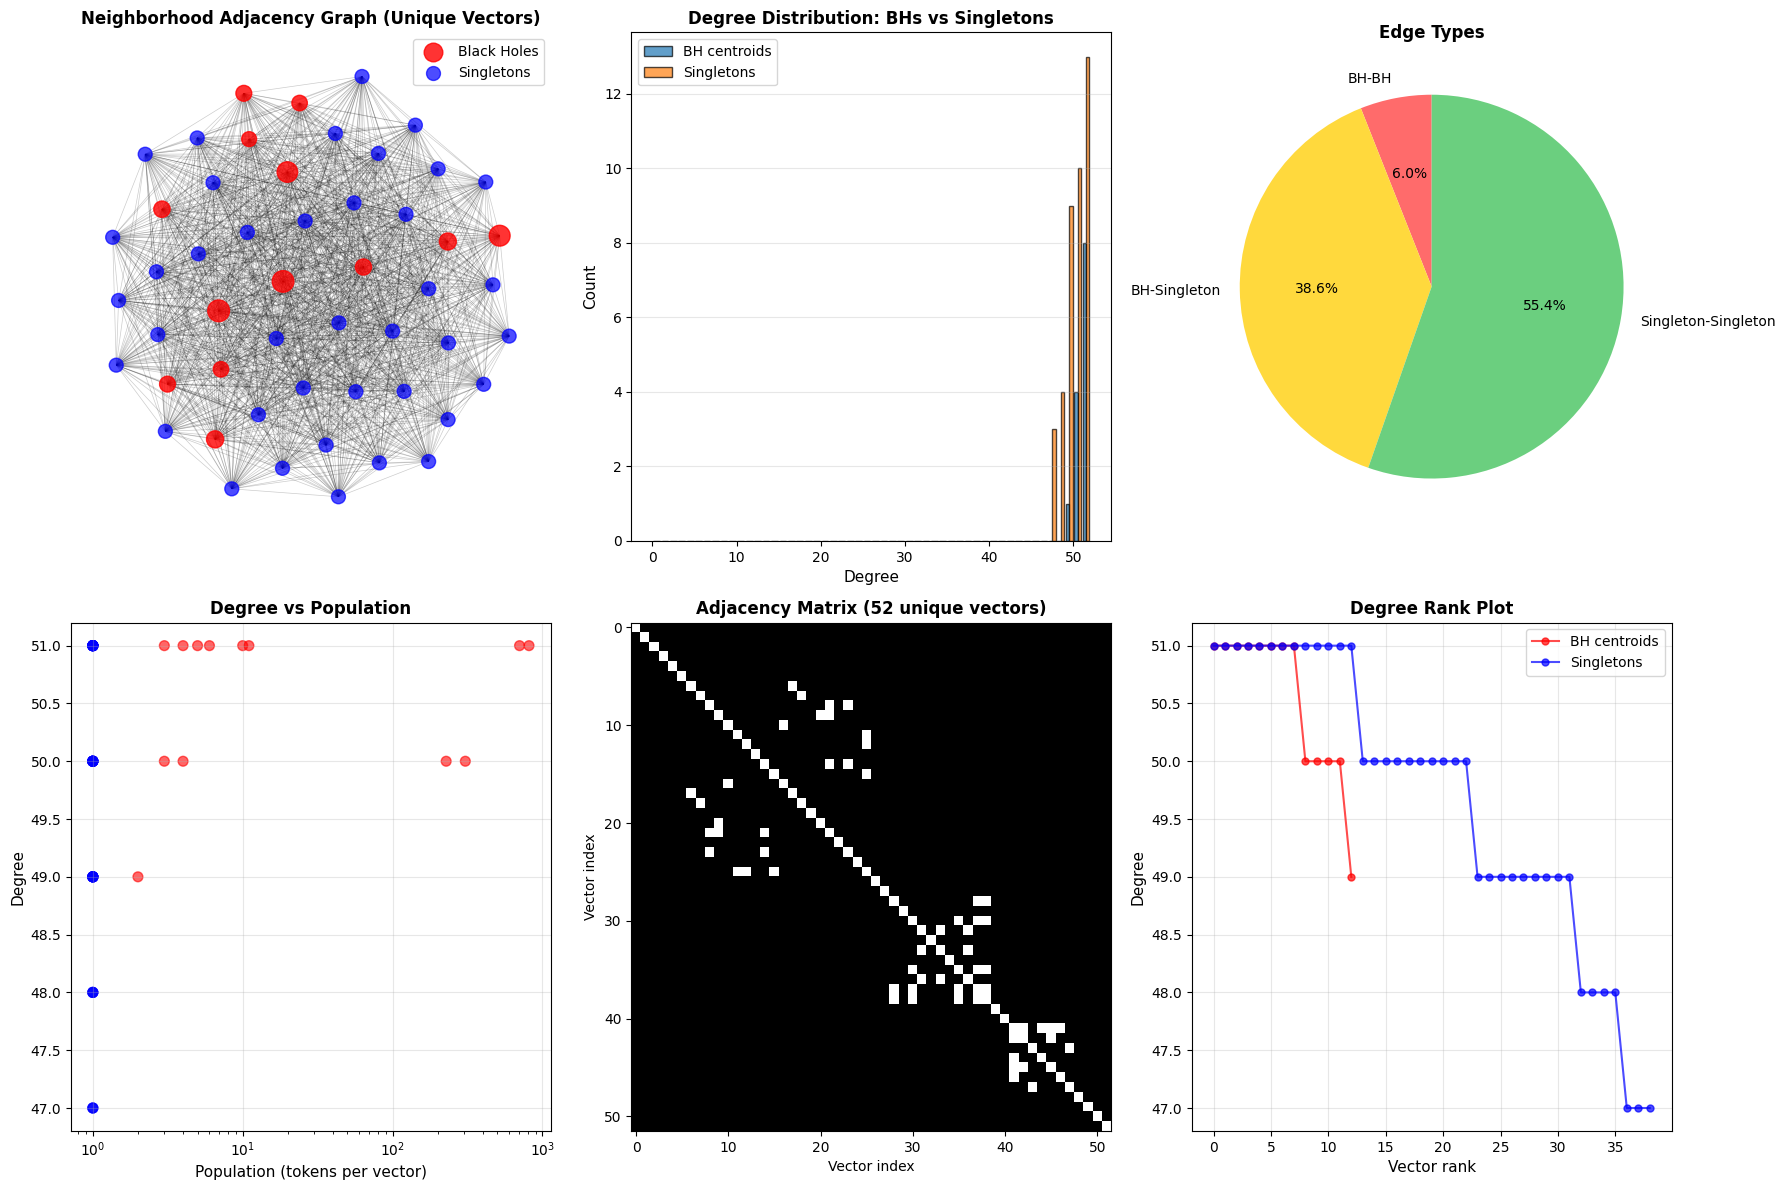

✓ Visualizations complete


In [28]:
print("\nCreating visualizations...\n")

fig = plt.figure(figsize=(18, 12), dpi=100)

# 1. Network graph (force-directed layout)
ax1 = plt.subplot(2, 3, 1)

print("Computing spring layout...")
pos = nx.spring_layout(G, seed=42, k=2.0, iterations=100)

# Separate node positions by type
bh_nodes = [i for i in range(n_unique) if unique_labels[i] == 'BH']
singleton_nodes = [i for i in range(n_unique) if unique_labels[i] == 'singleton']

# Node sizes proportional to population (log scale for visibility)
bh_sizes = [100 + 50 * np.log10(unique_populations[i]) for i in bh_nodes]
singleton_sizes = [100 for i in singleton_nodes]

# Draw BHs
nx.draw_networkx_nodes(G, pos, nodelist=bh_nodes, node_size=bh_sizes,
                       node_color='red', label='Black Holes', ax=ax1, alpha=0.8)

# Draw singletons
nx.draw_networkx_nodes(G, pos, nodelist=singleton_nodes, node_size=singleton_sizes,
                       node_color='blue', label='Singletons', ax=ax1, alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=ax1)

ax1.set_title('Neighborhood Adjacency Graph (Unique Vectors)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.axis('off')

# 2. Degree distribution comparison
ax2 = plt.subplot(2, 3, 2)
max_degree = max(degrees.values())
bins = range(0, max_degree + 2)
ax2.hist([bh_degrees, singleton_degrees], bins=bins,
         label=['BH centroids', 'Singletons'], edgecolor='black', alpha=0.7)
ax2.set_xlabel('Degree', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Degree Distribution: BHs vs Singletons', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# 3. Edge type pie chart
ax3 = plt.subplot(2, 3, 3)
edge_counts = [len(bh_bh_edges), len(bh_singleton_edges), len(singleton_singleton_edges)]
edge_labels = ['BH-BH', 'BH-Singleton', 'Singleton-Singleton']
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
ax3.pie(edge_counts, labels=edge_labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax3.set_title('Edge Types', fontsize=12, fontweight='bold')

# 4. Degree vs population scatter
ax4 = plt.subplot(2, 3, 4)
degrees_plot = [degrees[i] for i in range(n_unique)]
populations_plot = unique_populations
colors_plot = ['red' if unique_labels[i] == 'BH' else 'blue' for i in range(n_unique)]

ax4.scatter(populations_plot, degrees_plot, c=colors_plot, alpha=0.6, s=50)
ax4.set_xlabel('Population (tokens per vector)', fontsize=11)
ax4.set_ylabel('Degree', fontsize=11)
ax4.set_xscale('log')
ax4.set_title('Degree vs Population', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Adjacency matrix
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(adj_matrix.astype(int), cmap='binary', interpolation='nearest', aspect='auto')
ax5.set_title(f'Adjacency Matrix ({n_unique} unique vectors)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Vector index', fontsize=10)
ax5.set_ylabel('Vector index', fontsize=10)

# 6. Cumulative degree distribution
ax6 = plt.subplot(2, 3, 6)
sorted_bh_degrees = np.sort(bh_degrees)[::-1]
sorted_singleton_degrees = np.sort(singleton_degrees)[::-1]

ax6.plot(range(len(sorted_bh_degrees)), sorted_bh_degrees, 'o-',
         label='BH centroids', markersize=5, alpha=0.7, color='red')
ax6.plot(range(len(sorted_singleton_degrees)), sorted_singleton_degrees, 'o-',
         label='Singletons', markersize=5, alpha=0.7, color='blue')
ax6.set_xlabel('Vector rank', fontsize=11)
ax6.set_ylabel('Degree', fontsize=11)
ax6.set_title('Degree Rank Plot', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [30]:
print("\n" + "=" * 100)
print("SUMMARY: FULL NEIGHBORHOOD ADJACENCY GRAPH (UNIQUE VECTORS)")
print("=" * 100)
print()

print(f"Neighborhood: {n_full_neighborhood:,} tokens ({n_unique} unique vectors)")
print(f"  Black hole centroids: {n_unique_bh} ({sum(bh_populations):,} tokens)")
print(f"  Singleton vectors: {n_unique_singleton} ({sum(singleton_populations):,} tokens)")
print()

print(f"Graph structure:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges():,}")
print(f"  Connected components: {n_components}")
print()

print(f"Connectivity:")
print(f"  BH centroid mean degree: {np.mean(bh_degrees):.1f}")
print(f"  Singleton mean degree: {np.mean(singleton_degrees):.1f}")
print(f"  Ratio: {np.mean(bh_degrees) / np.mean(singleton_degrees):.2f}x")
print()

print(f"Edge composition:")
print(f"  BH-BH: {len(bh_bh_edges):,} ({100*len(bh_bh_edges)/G.number_of_edges():.1f}%)")
print(f"  BH-Singleton: {len(bh_singleton_edges):,} ({100*len(bh_singleton_edges)/G.number_of_edges():.1f}%)")
print(f"  Singleton-Singleton: {len(singleton_singleton_edges):,} ({100*len(singleton_singleton_edges)/G.number_of_edges():.1f}%)")
print()

print("Key findings:")
print()

if n_components == 1:
    print("  ✓ UNIFIED STRUCTURE")
    print("    All BH centroids and singleton vectors form one connected component.")
    print("    The diffusion cloud is integrated with the BH core.")
else:
    print("  ⚠ FRAGMENTED STRUCTURE")
    print(f"    {n_components} disconnected components.")
    print("    Some singleton vectors are isolated from the BH core.")

print()

if np.mean(bh_degrees) > 2 * np.mean(singleton_degrees):
    print("  ✓ CORE-PERIPHERY TOPOLOGY")
    print("    BH centroids are densely connected (core).")
    print("    Singleton vectors form sparse halo (periphery).")
    print("    This is the expected signature of thermal diffusion.")
elif np.mean(bh_degrees) > np.mean(singleton_degrees):
    print("  ~ MODERATE CORE-PERIPHERY")
    print("    BH centroids more connected than singletons, but structure is not extreme.")
else:
    print("  ⚠ UNIFORM CONNECTIVITY")
    print("    BH centroids and singleton vectors have similar degree.")
    print("    No clear core-periphery structure.")

print()

if len(bh_singleton_edges) > len(singleton_singleton_edges):
    print("  ✓ SINGLETONS CONNECT TO CORE")
    print("    More BH-singleton edges than singleton-singleton edges.")
    print("    Singletons are satellites around the BH core, not independent clusters.")
else:
    print("  ⚠ SINGLETON CLUSTERING")
    print("    Singletons connect more to each other than to BHs.")
    print("    This suggests independent singleton clusters.")

print()
print("=" * 100)


SUMMARY: FULL NEIGHBORHOOD ADJACENCY GRAPH (UNIQUE VECTORS)

Neighborhood: 2,139 tokens (52 unique vectors)
  Black hole centroids: 13 (2,100 tokens)
  Singleton vectors: 39 (39 tokens)

Graph structure:
  Nodes: 52
  Edges: 1,297
  Connected components: 1

Connectivity:
  BH centroid mean degree: 50.5
  Singleton mean degree: 49.7
  Ratio: 1.02x

Edge composition:
  BH-BH: 78 (6.0%)
  BH-Singleton: 501 (38.6%)
  Singleton-Singleton: 718 (55.4%)

Key findings:

  ✓ UNIFIED STRUCTURE
    All BH centroids and singleton vectors form one connected component.
    The diffusion cloud is integrated with the BH core.

  ~ MODERATE CORE-PERIPHERY
    BH centroids more connected than singletons, but structure is not extreme.

  ⚠ SINGLETON CLUSTERING
    Singletons connect more to each other than to BHs.
    This suggests independent singleton clusters.

